# Transfer Learning Part 1: feature extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem

There are two main benefits:

1. Can leverage an existing neural network architecture proven to work on problem similar to our own.
2. Can leverage a working neural network architecture which has already learned pattern on similar data to our own, then we can adapt those patterns to our own data.



## Import the dataset

In [ ]:
 !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-07-18 09:54:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.218.128, 108.177.12.128, 172.217.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   248MB/s    in 0.6s    

2022-07-18 09:54:26 (248 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:
import zipfile

zip=zipfile.ZipFile('/content/10_food_classes_10_percent.zip')
zip.extractall()
zip.close()

In [ ]:
import os

#walk through data
for dirpath,dirnames,filenames in os.walk('10_food_classes_10_percent'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} in {dirpath}')

There are 2 directories and 0 in 10_food_classes_10_percent
There are 10 directories and 0 in 10_food_classes_10_percent/test
There are 0 directories and 250 in 10_food_classes_10_percent/test/hamburger
There are 0 directories and 250 in 10_food_classes_10_percent/test/steak
There are 0 directories and 250 in 10_food_classes_10_percent/test/ice_cream
There are 0 directories and 250 in 10_food_classes_10_percent/test/chicken_curry
There are 0 directories and 250 in 10_food_classes_10_percent/test/pizza
There are 0 directories and 250 in 10_food_classes_10_percent/test/grilled_salmon
There are 0 directories and 250 in 10_food_classes_10_percent/test/chicken_wings
There are 0 directories and 250 in 10_food_classes_10_percent/test/fried_rice
There are 0 directories and 250 in 10_food_classes_10_percent/test/ramen
There are 0 directories and 250 in 10_food_classes_10_percent/test/sushi
There are 10 directories and 0 in 10_food_classes_10_percent/train
There are 0 directories and 75 in 10_fo

## Creating data loaders (preparing the data)

We will use the ImageDataGenerator class to load in our images in batches

In [ ]:
#setup data input

from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE=(224,224)
BATCH_SIZE=32

train_dir='10_food_classes_10_percent/train/'
test_dir='10_food_classes_10_percent/test/'

train_gen=ImageDataGenerator(rescale=1/255.)
test_gen=ImageDataGenerator(rescale=1/255.)

train_data_10_percent=train_gen.flow_from_directory(train_dir,
                                                    target_size=IMAGE_SHAPE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical')
test_data=test_gen.flow_from_directory(test_dir,
                                         target_size=IMAGE_SHAPE,
                                         batch_size=BATCH_SIZE,
                                         class_mode='categorical')

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model train)

Callbacks are extra functionality you can add to your models to be perfromed during or after training. Some of the popular callbacks:

* Tracking experiments with the TensorBoard callbacks
* Model checkpoint with the ModelCheckpoint callbacks
* Stopping model training to avoid overfitting

In [ ]:
# Creating a tensorborad callback (functionize because we need to create a new one for each model)
import datetime
import tensorflow as tf
def create_tensorboard_callback(dir_name,experiment_name):
  log_dir=dir_name+'/'+experiment_name+'/'+datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'Saving tensorbaord log files to : {log_dir}')
  return tensorboard_callback

You can customize the directory where your tensorboard logs get saved.

## Creating models using tensorflow hub

In the past we've used tensorflow to create our own models layer by layer from scratch
Now we are going to do a similar process, except the majority of our model's layers are going to come from tensorflow hub.
Access pretrained models from: https://tfhub.dev/

In tensorflow hub there are hundreds of model for one thing, how do we know which one to use? We want to use the model with model metrics in our domain and https://paperswithcode.com/ can help us with that.This actually comes from experience

We came across this model:
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [ ]:
resnet='https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
efficient_hub='https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'


In [ ]:
#Importing libraries
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
IMAGE_SHAPE+(3,)

#adds the 3 shape into 224,244 image 3 is for rgb values

(224, 224, 3)

In [ ]:
def create_model(model_url,num_classes=10):
  '''Takes a Tensorflow Hub URL and creates a Keras Sequential model with it
  
  Args:
      model_url(str): A tensorflow hub feature extraction URL.
      num_classes (int): Number of output neuron in the output layer,should be equal
      to number of target classes, default 10
      
  Returns:
      An uncompiled Keras Sequential model with model_url as feature extractor 
      layer and Dense output layer with num_classes output neurons'''

  #Download a pretrained model and save it as keras layer
  feature_extractor_layer=hub.KerasLayer(model_url,trainable=False,
                                         name='Feature_Extraction_layer',
                                         input_shape=IMAGE_SHAPE+(3,)) #freeze the already learned patterns
  model=tf.keras.Sequential([
          feature_extractor_layer,
          layers.Dense(num_classes,activation='softmax',name='Output_layer')
  ])
  return model

### Creating ResNet and testing Tensorflow Hub Feature Extraction model

In [ ]:
resnet_model=create_model(resnet, num_classes=train_data_10_percent.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature_Extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 Output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


This model has non-trainable parameters unlike the other models we have made before

In [ ]:
resnet_model.compile(loss=tf.keras.losses.binary_crossentropy,
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
resnet_history=resnet_model.fit(train_data_10_percent,
                 epochs=5,
                 steps_per_epoch=len(train_data_10_percent),
                 validation_data=test_data,
                 validation_steps=len(test_data),
                 callbacks=[create_tensorboard_callback('tensorflow_hub','resnet_model')])

Saving tensorbaord log files to : tensorflow_hub/resnet_model/20220718-095436
Epoch 1/5
24/24 [==============================] - 32s 1s/step - loss: 0.4026 - accuracy: 0.2187 - val_loss: 0.2715 - val_accuracy: 0.4368
Epoch 2/5
24/24 [==============================] - 16s 667ms/step - loss: 0.2219 - accuracy: 0.5987 - val_loss: 0.1886 - val_accuracy: 0.6972
Epoch 3/5
24/24 [==============================] - 16s 683ms/step - loss: 0.1633 - accuracy: 0.7547 - val_loss: 0.1596 - val_accuracy: 0.7492
Epoch 4/5
24/24 [==============================] - 16s 688ms/step - loss: 0.1340 - accuracy: 0.8080 - val_loss: 0.1474 - val_accuracy: 0.7632
Epoch 5/5
24/24 [==============================] - 16s 681ms/step - loss: 0.1154 - accuracy: 0.8587 - val_loss: 0.1380 - val_accuracy: 0.7876


Last time we tried to classify all 10 classes our training and testing accuracy was below 40 percent but using transfer learning we have increased it to 80 percent with lesser time and 10% of the training data

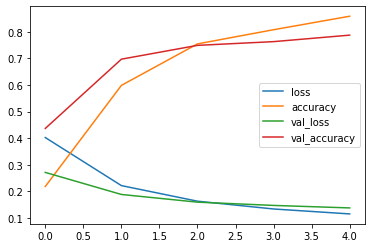

In [ ]:
#plotting loss curves
import pandas as pd
pd.DataFrame(resnet_history.history).plot()

### Creating Efficient and testing Tensorflow Hub Feature Extraction model

In [ ]:
efficient_model=create_model(efficient_hub,num_classes=train_data_10_percent.num_classes)

In [ ]:
efficient_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature_Extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 Output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
efficient_model.compile(loss=tf.keras.losses.binary_crossentropy,
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=['accuracy'])

In [ ]:
efficient_history=efficient_model.fit(train_data_10_percent,
                 epochs=5,
                 steps_per_epoch=len(train_data_10_percent),
                 validation_data=test_data,
                 validation_steps=len(test_data),
                 callbacks=[create_tensorboard_callback('tensorflow_hub','efficientNet_model')])

Saving tensorbaord log files to : tensorflow_hub/efficientNet_model/20220718-095622
Epoch 1/5
24/24 [==============================] - 25s 704ms/step - loss: 0.4179 - accuracy: 0.3013 - val_loss: 0.2839 - val_accuracy: 0.5696
Epoch 2/5
24/24 [==============================] - 15s 635ms/step - loss: 0.2515 - accuracy: 0.7013 - val_loss: 0.2208 - val_accuracy: 0.7676
Epoch 3/5
24/24 [==============================] - 15s 636ms/step - loss: 0.2001 - accuracy: 0.8147 - val_loss: 0.1836 - val_accuracy: 0.8128
Epoch 4/5
24/24 [==============================] - 15s 628ms/step - loss: 0.1707 - accuracy: 0.8320 - val_loss: 0.1620 - val_accuracy: 0.8396
Epoch 5/5
24/24 [==============================] - 15s 628ms/step - loss: 0.1503 - accuracy: 0.8520 - val_loss: 0.1470 - val_accuracy: 0.8464


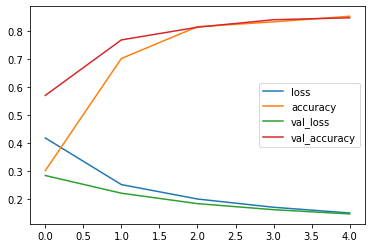

In [ ]:
#Creating loss and accuracy curve for efficient net model
pd.DataFrame(efficient_history.history).plot()

In [ ]:
#Check tensorbaord using these two commands
#%load_ext tensorboard
#%tensorboard --logdir tensorflow_hub

In [ ]:
## Training for more epochs

efficient_history=efficient_model.fit(train_data_10_percent,
                 epochs=5,
                 steps_per_epoch=len(train_data_10_percent),
                 validation_data=test_data,
                 validation_steps=len(test_data),
                 callbacks=[create_tensorboard_callback('tensorflow_hub','efficientNet_model')])

Saving tensorbaord log files to : tensorflow_hub/efficientNet_model/20220718-095753
Epoch 1/5
24/24 [==============================] - 16s 664ms/step - loss: 0.1357 - accuracy: 0.8667 - val_loss: 0.1362 - val_accuracy: 0.8568
Epoch 2/5
24/24 [==============================] - 15s 632ms/step - loss: 0.1243 - accuracy: 0.8827 - val_loss: 0.1284 - val_accuracy: 0.8600
Epoch 3/5
24/24 [==============================] - 15s 635ms/step - loss: 0.1149 - accuracy: 0.8920 - val_loss: 0.1215 - val_accuracy: 0.8680
Epoch 4/5
24/24 [==============================] - 15s 629ms/step - loss: 0.1072 - accuracy: 0.9067 - val_loss: 0.1166 - val_accuracy: 0.8680
Epoch 5/5
24/24 [==============================] - 15s 630ms/step - loss: 0.1002 - accuracy: 0.9080 - val_loss: 0.1120 - val_accuracy: 0.8720


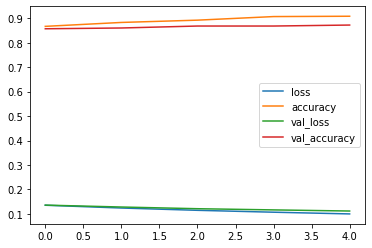

In [ ]:
#Creating loss and accuracy curve for efficient net model after 10 epochs
pd.DataFrame(efficient_history.history).plot()

Efficient net b0 is performing the best in all these.

## Different types of transfer learning
* **"As is" transfer learning** - Using an existing model with no changes whatsoever(e.g using ImageNet model on 1000 ImageNet classes, none of your own)
* **"Feature Extraction" Transfer learning** - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on imagenet) and adjust the output layer for your own problem (e.g 1000 classes -> 10 classes of food)
* **"Fine tuning" transfer learning** - Use the prelearned pattern of an existing model and "fine_tune" many or all the underlyinh layers (including new output layers)

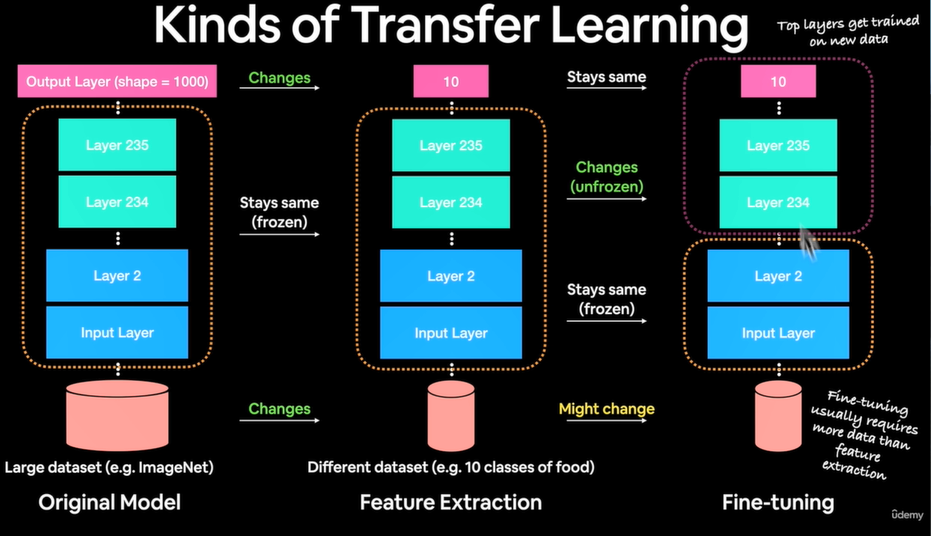

## Comparing model results

**Note:** When you upload things to tensorflow.dev, your experiment are public. So, if you're running private experiment (things you don't want others to see) do not upload them to tensorboard.dev

In [ ]:
#How to upload to tensorboard dev records
""" 
  !tensorflow dev upload --logdir ./tensorflow_hub/ \
  --name 'EfficientNetB00 vs ResNet50V2' \
  --description 'Comparing two different TF Hub feature extraction model architectures using 10% of the data' \
  --one_shot 
  """

" \n  !tensorflow dev upload --logdir ./tensorflow_hub/   --name 'EfficientNetB00 vs ResNet50V2'   --description 'Comparing two different TF Hub feature extraction model architectures using 10% of the data'   --one_shot \n  "

In [ ]:
#check out the experiment we have after uploading to the tensorboard
#!tensorboard dev list


***** TensorBoard Uploader *****

This will list all experiments that you've uploaded to
https://tensorboard.dev. TensorBoard.dev experiments are visible
to everyone. Do not upload sensitive data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/main.py", line 46, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 312, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.7/dist-pac

In [ ]:
# Comparing model results using tensorboard in jupyter notebook
#%load_ext tensorboard
#%tensorboard --logdir tensorflow_hub

NameError: ignored